# ResNet-Based mmFace

In [1]:
import torch
import torch.nn as nn
# from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=50):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=1)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(1, stride=2)
        self.fc1 = nn.Sequential(
            nn.Linear(512*4*2, 512),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes)
            )
        layers = [block(self.inplanes, planes, stride, downsample)] + [block(planes, planes) for _ in range(blocks-1)]
        self.inplanes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # TODO: MAYBE STOP HERE FOR 512D EMBEDDING???
        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

class MMFace(nn.Module):
    def __init__(self, num_classes=50):
        super(MMFace, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.maxpool =  nn.MaxPool2d(kernel_size=3)
        self.fc1 = nn.Sequential(
            nn.Linear(128*8*2, 1024),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512, 32),
            nn.ReLU()
        )
        self.fc4 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool(x)
        # Flatten vector before FC layers
        x = x.reshape(-1, 128*8*2)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x

cuda


## Loading Dataset and Model

In [2]:
import sys
import numpy as np
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

subjects = sorted(list(np.random.choice(range(1, 20), 1, replace=False)) + [4, 14, 16, 20])
np.array(anon_names)[subjects]

array(['Joseph Parker', 'Amy Eden', 'Chloë Smart', 'Barkin Bryce',
       'Chaitanya Kaul'], dtype='<U19')

In [2]:
from dataset_builder import normalise, load_dataset_DL, load_dataset
from torchvision.transforms import Compose, ToTensor
import os
import numpy as np

def load_model(name, model, optimiser):
    epoch = 0
    loss_history, train_acc, val_acc = [], [], []
    try:
        checkpoint = torch.load(f"models/{name}")
        model.load_state_dict(checkpoint["model_state_dict"])
        optimiser.load_state_dict(checkpoint["optimiser_state_dict"])
        epoch = checkpoint["epoch"]
        loss_history = checkpoint["loss_history"]
        train_acc = checkpoint["train_acc"]
        val_acc = checkpoint["val_acc"]
    except Exception as ex:
        print(ex)
    
    return epoch, loss_history, train_acc, val_acc

def load_history(model_path):
    checkpoint = torch.load(model_path)
    return checkpoint["loss_history"], checkpoint["train_acc"], checkpoint["val_acc"]

num_frames = 250
# train, validation, test = load_dataset_DL(os.path.relpath("../../Soli/soli_realsense/data"), range(num_classes), batch_size=128, transform=Compose([normalise, ToTensor()]))

subjects = [0, 4, 9, 14, 16, 20]
# subjects = sorted(np.random.choice(range(19), 4, replace=False))
# subjects = [4, 14, 16, 20] # -> 55%
num_classes = len(subjects)
experiments = list(range(15))
lighting_only = experiments[:5] + experiments[10:]
torch.cuda.empty_cache()
train, validation, test = load_dataset(os.path.relpath("../../Soli/soli_realsense/data"), subjects, experiments=experiments, num_frames=num_frames, batch_size=128)

Train: torch.Size([17985, 3, 32, 16])
Validation: torch.Size([2250, 3, 32, 16])
Test: torch.Size([2250, 3, 32, 16])
Allocated: 0.28 GB


## Hyperparameters + Loss + Optimiser

In [3]:
# from neural_nets import MMFace_Padding, MMFace

num_epochs = 50
learning_rate = 0.01

# model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes).to(device)
model = MMFace(num_classes).to(device)

# model = resnet18(weights=ResNet18_Weights.DEFAULT)
# model = resnet50(weights=ResNet50_Weights.DEFAULT)
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = f"mmFace-simple{num_classes}-hope.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, optimiser)

# FINETUNING: FREEZE PRETRAINED PARAMETERS FOR FIRST FEW EPOCHS
# for param in model.parameters():
#     param.requires_grad = True
# model = model.to(device)

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]:.4f}\n\tValidation Accuracy: {val_acc[-1]:.4f}")

[Errno 2] No such file or directory: 'models/mmFace-simple6-hope.pt'


## Training
- Load training data in ***batches*** for every epoch, moving to `device`
  - `train_loader` = `[([data*], [labels*])*]`
- `model(data)` to predict label, then calculate loss between predictions and ground truth labels using `criterion(preds, labels)`
- Backpropagate to learn with `loss.backward()`, and update weights with `optimiser.step()`. Gradients must be reset to 0 after every update with `optimiser.zero_grad()` otherwise gradients will accumulate (default PyTorch).
- After every epoch, test model on validation set but can turn off gradients for faster evaluation using `with torch.no_grad()`.

In [4]:
for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if os.path.exists(f"models/{model_name}"):
        loss_history, train_acc, val_acc = load_history(f"models/{model_name}")

    model.train()
    # Running Loss and Accuracy
    running_loss, running_acc, total = 0., 0., 0.

    for data, labels in tqdm(train):
        # Forward Pass
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total += labels.size(0)
        running_acc += (predicted == labels).sum().item()

        del data, labels, outputs
        torch.cuda.empty_cache()
    
    avg_train_loss = running_loss/len(train)
    avg_train_acc = 100*running_acc/total
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tTrain Accuracy: {avg_train_acc:.4f}%")

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "loss_history": loss_history + [avg_train_loss],
                "train_acc": train_acc + [avg_train_acc],
                "val_acc": val_acc},
                f"models/{model_name}")
    
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in validation:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del data, labels, outputs
        
        avg_val_acc = 100*correct/total
        print(f"\tValidation Accuracy: {avg_val_acc:.4f}%")

    model_checkpoint = torch.load(f"models/{model_name}")
    model_checkpoint["val_acc"].append(avg_val_acc)
    torch.save(model_checkpoint, f"models/{model_name}")

    # Stop if overfitting
    if avg_train_acc - avg_val_acc > 10:
        break


Epoch [0/49]:


100%|██████████| 141/141 [00:02<00:00, 52.15it/s]


	Average Train Loss: 1.7313
	Train Accuracy: 22.5799%
	Validation Accuracy: 29.0222%

Epoch [1/49]:


100%|██████████| 141/141 [00:02<00:00, 60.75it/s]


	Average Train Loss: 1.5253
	Train Accuracy: 33.8449%
	Validation Accuracy: 35.7333%

Epoch [2/49]:


100%|██████████| 141/141 [00:02<00:00, 64.46it/s]


	Average Train Loss: 1.4739
	Train Accuracy: 36.3581%
	Validation Accuracy: 36.3111%

Epoch [3/49]:


100%|██████████| 141/141 [00:02<00:00, 63.12it/s]


	Average Train Loss: 1.4531
	Train Accuracy: 37.1254%
	Validation Accuracy: 37.2444%

Epoch [4/49]:


100%|██████████| 141/141 [00:02<00:00, 61.98it/s]


	Average Train Loss: 1.4375
	Train Accuracy: 38.0484%
	Validation Accuracy: 37.6000%

Epoch [5/49]:


100%|██████████| 141/141 [00:02<00:00, 62.78it/s]


	Average Train Loss: 1.4229
	Train Accuracy: 38.8657%
	Validation Accuracy: 37.9111%

Epoch [6/49]:


100%|██████████| 141/141 [00:02<00:00, 63.99it/s]


	Average Train Loss: 1.4114
	Train Accuracy: 39.1493%
	Validation Accuracy: 38.2222%

Epoch [7/49]:


100%|██████████| 141/141 [00:02<00:00, 63.12it/s]


	Average Train Loss: 1.4009
	Train Accuracy: 39.3495%
	Validation Accuracy: 38.8000%

Epoch [8/49]:


100%|██████████| 141/141 [00:02<00:00, 63.16it/s]


	Average Train Loss: 1.3912
	Train Accuracy: 39.6775%
	Validation Accuracy: 39.2889%

Epoch [9/49]:


100%|██████████| 141/141 [00:02<00:00, 60.92it/s]


	Average Train Loss: 1.3821
	Train Accuracy: 40.3281%
	Validation Accuracy: 39.5556%

Epoch [10/49]:


100%|██████████| 141/141 [00:02<00:00, 63.20it/s]


	Average Train Loss: 1.3736
	Train Accuracy: 40.6561%
	Validation Accuracy: 40.0444%

Epoch [11/49]:


100%|██████████| 141/141 [00:02<00:00, 60.57it/s]


	Average Train Loss: 1.3656
	Train Accuracy: 41.0342%
	Validation Accuracy: 39.6444%

Epoch [12/49]:


100%|██████████| 141/141 [00:02<00:00, 61.61it/s]


	Average Train Loss: 1.3590
	Train Accuracy: 41.3789%
	Validation Accuracy: 39.4222%

Epoch [13/49]:


100%|██████████| 141/141 [00:02<00:00, 60.08it/s]


	Average Train Loss: 1.3529
	Train Accuracy: 41.7070%
	Validation Accuracy: 39.7333%

Epoch [14/49]:


100%|██████████| 141/141 [00:02<00:00, 61.48it/s]


	Average Train Loss: 1.3466
	Train Accuracy: 41.9794%
	Validation Accuracy: 39.6889%

Epoch [15/49]:


100%|██████████| 141/141 [00:02<00:00, 58.05it/s]


	Average Train Loss: 1.3395
	Train Accuracy: 42.4242%
	Validation Accuracy: 39.1111%

Epoch [16/49]:


100%|██████████| 141/141 [00:02<00:00, 59.36it/s]


	Average Train Loss: 1.3322
	Train Accuracy: 42.7245%
	Validation Accuracy: 39.4222%

Epoch [17/49]:


100%|██████████| 141/141 [00:02<00:00, 57.59it/s]


	Average Train Loss: 1.3246
	Train Accuracy: 43.1915%
	Validation Accuracy: 39.7333%

Epoch [18/49]:


100%|██████████| 141/141 [00:02<00:00, 59.93it/s]


	Average Train Loss: 1.3169
	Train Accuracy: 43.5752%
	Validation Accuracy: 39.7778%

Epoch [19/49]:


100%|██████████| 141/141 [00:02<00:00, 58.27it/s]


	Average Train Loss: 1.3099
	Train Accuracy: 43.9477%
	Validation Accuracy: 39.9111%

Epoch [20/49]:


100%|██████████| 141/141 [00:02<00:00, 57.42it/s]


	Average Train Loss: 1.3018
	Train Accuracy: 44.2202%
	Validation Accuracy: 40.4889%

Epoch [21/49]:


100%|██████████| 141/141 [00:02<00:00, 56.43it/s]


	Average Train Loss: 1.2898
	Train Accuracy: 44.9541%
	Validation Accuracy: 40.9778%

Epoch [22/49]:


100%|██████████| 141/141 [00:02<00:00, 57.11it/s]


	Average Train Loss: 1.2755
	Train Accuracy: 45.6158%
	Validation Accuracy: 41.1111%

Epoch [23/49]:


100%|██████████| 141/141 [00:02<00:00, 54.98it/s]


	Average Train Loss: 1.2611
	Train Accuracy: 46.5277%
	Validation Accuracy: 41.0222%

Epoch [24/49]:


100%|██████████| 141/141 [00:02<00:00, 55.93it/s]


	Average Train Loss: 1.2442
	Train Accuracy: 47.1615%
	Validation Accuracy: 40.6667%

Epoch [25/49]:


100%|██████████| 141/141 [00:02<00:00, 55.17it/s]


	Average Train Loss: 1.2245
	Train Accuracy: 48.5238%
	Validation Accuracy: 40.4000%

Epoch [26/49]:


100%|██████████| 141/141 [00:02<00:00, 55.72it/s]


	Average Train Loss: 1.1979
	Train Accuracy: 49.4078%
	Validation Accuracy: 41.3778%

Epoch [27/49]:


100%|██████████| 141/141 [00:02<00:00, 53.36it/s]


	Average Train Loss: 1.1698
	Train Accuracy: 50.7089%
	Validation Accuracy: 42.1333%

Epoch [28/49]:


100%|██████████| 141/141 [00:02<00:00, 54.41it/s]


	Average Train Loss: 1.1413
	Train Accuracy: 51.9266%
	Validation Accuracy: 40.3111%


## Testing

In [5]:
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())
        del data, labels, outputs
    
    print(f"Test Accuracy of mmFace: {100*correct/total:.4f}%")

Test Accuracy of mmFace: 42.1333%


# Evaluation

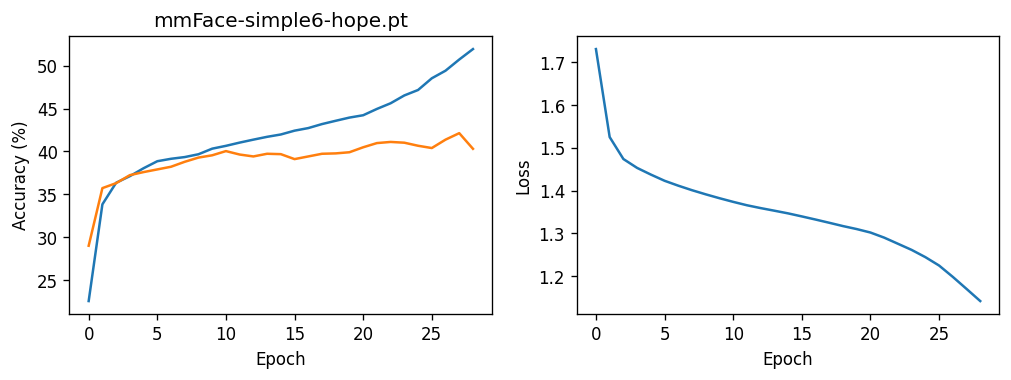

In [6]:
import matplotlib.pyplot as plt

losses, train_acc, val_acc = load_history(f"models/{model_name}")

fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=120)

axs[0].plot(range(len(train_acc)), train_acc)
axs[0].plot(range(len(val_acc)), val_acc)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(range(len(losses)), losses)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

axs[0].set_title(model_name)
plt.show()

[Text(0.5, 25.722222222222214, 'Predictions'),
 Text(145.72222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

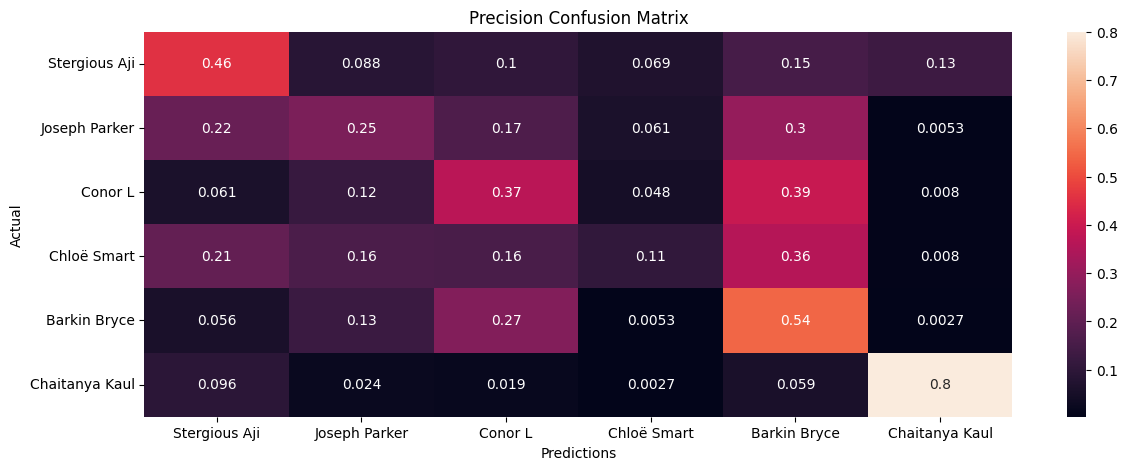

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

subject_names = np.array(anon_names)[subjects]
# subjects = range(num_classes)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=subject_names, columns=subject_names)
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')